In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = 'C:\\Users\\sin00\\Downloads\\ecg_dataset\\'
sampling_rate=100

Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

X = load_raw_data(Y, sampling_rate, path)

agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

empty_indices = Y[Y['diagnostic_superclass'].apply(len) == 0].index

Y_filtered = Y.drop(empty_indices)

empty_indices -= 1

X_filtered = np.delete(X, empty_indices, axis=0)

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
Y_data_encoded = mlb.fit_transform(Y_filtered['diagnostic_superclass'])

In [2]:
from sklearn.model_selection import train_test_split
import torch

X_filtered_transposed = X_filtered.transpose(0, 2, 1)

X_filtered_tensor = torch.tensor(X_filtered_transposed, dtype=torch.float32)
Y_data_encoded_tensor = torch.tensor(Y_data_encoded, dtype=torch.float32)

X_train_transposed_tensor, X_test_transposed_tensor, Y_train_tensor, Y_test_tensor = train_test_split(X_filtered_tensor, Y_data_encoded_tensor, test_size=0.2, random_state=42)

class_names = ['NORM', 'CD', 'MI', 'STTC', 'HYP']

num_classes = Y_data_encoded.shape[1]

ECG_sequence_length = X_filtered.shape[1]

ECG_channels = X_filtered.shape[2]

input_sequence_length = ECG_sequence_length

input_length = 1000

In [3]:
print("X_filtered shape:", X_filtered.shape)
print("X_filtered_transposed shape:", X_filtered_transposed.shape)
print("Y_data_encoded shape:", Y_data_encoded.shape)

print("X_filtered_tensor shape:", X_filtered_tensor.shape)
print("Y_data_encoded_tensor shape:", Y_data_encoded_tensor.shape)
print("X_train_tensor shape:", X_train_transposed_tensor.shape)
print("X_test_tensor shape:", X_test_transposed_tensor.shape)
print("Y_train_tensor shape:", Y_train_tensor.shape)
print("Y_test_tensor shape:", Y_test_tensor.shape)

X_filtered shape: (21430, 1000, 12)
X_filtered_transposed shape: (21430, 12, 1000)
Y_data_encoded shape: (21430, 5)
X_filtered_tensor shape: torch.Size([21430, 12, 1000])
Y_data_encoded_tensor shape: torch.Size([21430, 5])
X_train_tensor shape: torch.Size([17144, 12, 1000])
X_test_tensor shape: torch.Size([4286, 12, 1000])
Y_train_tensor shape: torch.Size([17144, 5])
Y_test_tensor shape: torch.Size([4286, 5])


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import time
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
import torch.nn.utils.prune as prune

# Define the CustomCNN class
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(12, 50, kernel_size=10),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(50, 150, kernel_size=10),
            nn.BatchNorm1d(150),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(150, 300, kernel_size=10),
            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(300, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.avg_pool(x).squeeze()
        x = self.dropout(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


# Define a function to apply pruning to the model
def apply_pruning(model, prune_rate=0.2):
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv1d, nn.Linear)):
            prune.l1_unstructured(module, name="weight", amount=prune_rate)
    
# Function to train the model with LR scheduler and model saving
def train_model_with_scheduler(model, train_loader, val_loader, num_epochs, device, patience, fold_index):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=patience // 2, factor=0.5, verbose=True)
    best_val_loss = float('inf')
    no_improvement_count = 0
    val_accuracies = []  # Initialize a list to store validation accuracies

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        start_time = time.time()
        for batch_X, batch_Y in train_loader:
            optimizer.zero_grad()
            batch_X = batch_X.to(device, dtype=torch.float32)
            batch_Y = batch_Y.to(device, dtype=torch.float32)
            output = model(batch_X)
            loss = criterion(output, batch_Y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        elapsed_time = time.time() - start_time

        model.eval()
        val_predictions = []
        val_true_labels = []
        with torch.no_grad():
            for batch_X, batch_Y in val_loader:
                batch_X = batch_X.to(device, dtype=torch.float32)
                val_output = model(batch_X)
                val_predictions.extend(val_output.cpu().numpy())
                val_true_labels.extend(batch_Y.cpu().numpy())

        val_predictions = np.array(val_predictions)
        val_true_labels = np.array(val_true_labels)

        val_accuracy = accuracy_score(val_true_labels, (val_predictions > 0.5).astype(int))
        val_accuracies.append(val_accuracy)  # Append validation accuracy to the list

        fold_loss = criterion(torch.Tensor(val_predictions), torch.Tensor(val_true_labels))

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Loss: {average_loss:.4f}, "
              f"Training Accuracy: {val_accuracy:.4f}, "
              f"Validation Loss: {fold_loss.item():.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}, "
              f"Training Time: {elapsed_time:.2f} seconds")

        # Update learning rate based on validation loss
        scheduler.step(fold_loss)

        # Save the model if it's the best so far
        if fold_loss < best_val_loss:
            best_val_loss = fold_loss
            no_improvement_count = 0
            # Save the model state
            torch.save(model.state_dict(), f'best_custom_cnn_model_fold{fold_index}.pth')

        if average_loss < best_val_loss:
            best_val_loss = average_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
            break

    # Calculate the average validation accuracy
    average_val_accuracy = np.mean(val_accuracies)
    return average_val_accuracy, fold_loss.item()

# Constants
num_folds = 5
batch_size = 64
num_epochs = 200
patience = 5

# Data preparation
multilabel_stratified_kfold = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_losses = []
fold_accuracies = []

device = torch.device("cpu")
    
# Training loop with LR scheduler and quantized_model saving
for fold_index, (train_idx, val_idx) in enumerate(multilabel_stratified_kfold.split(X_train_transposed_tensor, Y_train_tensor)):
    num_train_samples = len(train_idx)
    num_val_samples = len(val_idx)
    print(f"Fold {fold_index + 1}/{num_folds} - Train samples: {num_train_samples}, Validation samples: {num_val_samples}")

    X_train_fold_transposed_tensor, X_val_fold_transposed_tensor = X_train_transposed_tensor[train_idx], X_train_transposed_tensor[val_idx]
    Y_train_fold_tensor, Y_val_fold_tensor = Y_train_tensor[train_idx], Y_train_tensor[val_idx]

    X_train_fold_transposed_tensor = X_train_fold_transposed_tensor.to(device)
    Y_train_fold_tensor = Y_train_fold_tensor.to(device)
    X_val_fold_transposed_tensor = X_val_fold_transposed_tensor.to(device)
    Y_val_fold_tensor = Y_val_fold_tensor.to(device)
    
    train_fold_dataset = TensorDataset(X_train_fold_transposed_tensor, Y_train_fold_tensor)
    val_fold_dataset = TensorDataset(X_val_fold_transposed_tensor, Y_val_fold_tensor)

    train_fold_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
    val_fold_loader = DataLoader(val_fold_dataset, batch_size=batch_size)

    num_classes = Y_data_encoded.shape[1]
    
    # Create a new instance of CustomCNN
    quantized_model = CustomCNN(num_classes)

    # Load only matching keys from the model's state_dict
    state_dict = model.state_dict()
    new_state_dict = quantized_model.state_dict()
    for name, param in state_dict.items():
        if name in new_state_dict:
            new_state_dict[name].copy_(param)

    # Quantize the new instance
    quantized_model = torch.quantization.quantize_dynamic(
        quantized_model,
        {nn.Conv1d, nn.BatchNorm1d, nn.ReLU, nn.MaxPool1d},
        dtype=torch.qint8
    )

    quantized_model = quantized_model.to(device)

    # Apply pruning to the quantized model
    apply_pruning(quantized_model, prune_rate=0.1)

    val_accuracy, fold_loss = train_model_with_scheduler(quantized_model, train_fold_loader, val_fold_loader, num_epochs, device, patience, fold_index)

    # Append fold_loss and val_accuracy to their respective lists
    fold_losses.append(fold_loss)
    fold_accuracies.append(val_accuracy)
    
    print(f"Fold {fold_index + 1} - Validation Loss: {fold_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Calculate and print quantized_model size
    model_size = sum(p.numel() for p in quantized_model.parameters() if p.requires_grad) / 1e6
    print(f"Model Size: {model_size:.2f} MB")

# Calculate and print the average validation loss
average_fold_loss = np.mean(fold_losses)
average_accuracy = np.mean(fold_accuracies)
print(f"Average Validation Loss Across {num_folds} Folds: {average_fold_loss:.4f}")
print(f"Average Validation Accuracy Across {num_folds} Folds: {average_accuracy:.4f}")

Fold 1/5 - Train samples: 13723, Validation samples: 3421
Epoch 1/200, Loss: 0.3576, Training Accuracy: 0.5291, Validation Loss: 0.3358, Validation Accuracy: 0.5291, Training Time: 129.00 seconds
Epoch 2/200, Loss: 0.3136, Training Accuracy: 0.5867, Validation Loss: 0.3035, Validation Accuracy: 0.5867, Training Time: 129.98 seconds
Epoch 3/200, Loss: 0.3001, Training Accuracy: 0.5697, Validation Loss: 0.2945, Validation Accuracy: 0.5697, Training Time: 130.27 seconds
Epoch 4/200, Loss: 0.2890, Training Accuracy: 0.5896, Validation Loss: 0.2815, Validation Accuracy: 0.5896, Training Time: 129.90 seconds
Epoch 5/200, Loss: 0.2848, Training Accuracy: 0.6048, Validation Loss: 0.2773, Validation Accuracy: 0.6048, Training Time: 129.80 seconds
Epoch 6/200, Loss: 0.2784, Training Accuracy: 0.5782, Validation Loss: 0.3498, Validation Accuracy: 0.5782, Training Time: 130.02 seconds
Epoch 7/200, Loss: 0.2747, Training Accuracy: 0.6141, Validation Loss: 0.2712, Validation Accuracy: 0.6141, Traini

Epoch 3/200, Loss: 0.3049, Training Accuracy: 0.5973, Validation Loss: 0.2909, Validation Accuracy: 0.5973, Training Time: 129.48 seconds
Epoch 4/200, Loss: 0.2976, Training Accuracy: 0.6089, Validation Loss: 0.2806, Validation Accuracy: 0.6089, Training Time: 129.70 seconds
Epoch 5/200, Loss: 0.2867, Training Accuracy: 0.5859, Validation Loss: 0.2916, Validation Accuracy: 0.5859, Training Time: 128.96 seconds
Epoch 6/200, Loss: 0.2810, Training Accuracy: 0.5996, Validation Loss: 0.2950, Validation Accuracy: 0.5996, Training Time: 129.36 seconds
Epoch 7/200, Loss: 0.2771, Training Accuracy: 0.6092, Validation Loss: 0.2753, Validation Accuracy: 0.6092, Training Time: 129.45 seconds
Epoch 8/200, Loss: 0.2709, Training Accuracy: 0.6232, Validation Loss: 0.2640, Validation Accuracy: 0.6232, Training Time: 129.14 seconds
Epoch 9/200, Loss: 0.2706, Training Accuracy: 0.6168, Validation Loss: 0.2794, Validation Accuracy: 0.6168, Training Time: 129.09 seconds
Epoch 10/200, Loss: 0.2655, Traini

Epoch 10/200, Loss: 0.2607, Training Accuracy: 0.5029, Validation Loss: 0.3456, Validation Accuracy: 0.5029, Training Time: 129.35 seconds
Epoch 11/200, Loss: 0.2598, Training Accuracy: 0.5835, Validation Loss: 0.3259, Validation Accuracy: 0.5835, Training Time: 129.08 seconds
Epoch 12/200, Loss: 0.2565, Training Accuracy: 0.6114, Validation Loss: 0.2839, Validation Accuracy: 0.6114, Training Time: 129.47 seconds
Epoch 13/200, Loss: 0.2546, Training Accuracy: 0.6265, Validation Loss: 0.2802, Validation Accuracy: 0.6265, Training Time: 129.48 seconds
Epoch 14/200, Loss: 0.2505, Training Accuracy: 0.6172, Validation Loss: 0.2754, Validation Accuracy: 0.6172, Training Time: 129.83 seconds
Epoch 15/200, Loss: 0.2466, Training Accuracy: 0.6213, Validation Loss: 0.2712, Validation Accuracy: 0.6213, Training Time: 129.49 seconds
Epoch 16/200, Loss: 0.2443, Training Accuracy: 0.5765, Validation Loss: 0.2877, Validation Accuracy: 0.5765, Training Time: 129.51 seconds
Epoch 17/200, Loss: 0.2402,

Epoch 11/200, Loss: 0.2517, Training Accuracy: 0.6119, Validation Loss: 0.2843, Validation Accuracy: 0.6119, Training Time: 129.79 seconds
Epoch 12/200, Loss: 0.2475, Training Accuracy: 0.6349, Validation Loss: 0.2655, Validation Accuracy: 0.6349, Training Time: 129.69 seconds
Epoch 13/200, Loss: 0.2477, Training Accuracy: 0.6303, Validation Loss: 0.2729, Validation Accuracy: 0.6303, Training Time: 129.79 seconds
Epoch 14/200, Loss: 0.2442, Training Accuracy: 0.6151, Validation Loss: 0.2713, Validation Accuracy: 0.6151, Training Time: 129.73 seconds
Epoch 15/200, Loss: 0.2410, Training Accuracy: 0.6213, Validation Loss: 0.2751, Validation Accuracy: 0.6213, Training Time: 129.47 seconds
Epoch 00015: reducing learning rate of group 0 to 2.5000e-04.
Epoch 16/200, Loss: 0.2309, Training Accuracy: 0.6402, Validation Loss: 0.2587, Validation Accuracy: 0.6402, Training Time: 129.56 seconds
Epoch 17/200, Loss: 0.2308, Training Accuracy: 0.6413, Validation Loss: 0.2651, Validation Accuracy: 0.6

Epoch 25/200, Loss: 0.2171, Training Accuracy: 0.6294, Validation Loss: 0.2590, Validation Accuracy: 0.6294, Training Time: 131.20 seconds
Epoch 00025: reducing learning rate of group 0 to 3.1250e-05.
Epoch 26/200, Loss: 0.2155, Training Accuracy: 0.6358, Validation Loss: 0.2580, Validation Accuracy: 0.6358, Training Time: 130.79 seconds
Epoch 27/200, Loss: 0.2149, Training Accuracy: 0.6373, Validation Loss: 0.2598, Validation Accuracy: 0.6373, Training Time: 130.84 seconds
Epoch 28/200, Loss: 0.2151, Training Accuracy: 0.6352, Validation Loss: 0.2599, Validation Accuracy: 0.6352, Training Time: 131.37 seconds
Epoch 00028: reducing learning rate of group 0 to 1.5625e-05.
Epoch 29/200, Loss: 0.2136, Training Accuracy: 0.6350, Validation Loss: 0.2585, Validation Accuracy: 0.6350, Training Time: 130.82 seconds
Epoch 30/200, Loss: 0.2124, Training Accuracy: 0.6382, Validation Loss: 0.2604, Validation Accuracy: 0.6382, Training Time: 130.79 seconds
Epoch 31/200, Loss: 0.2102, Training Accur

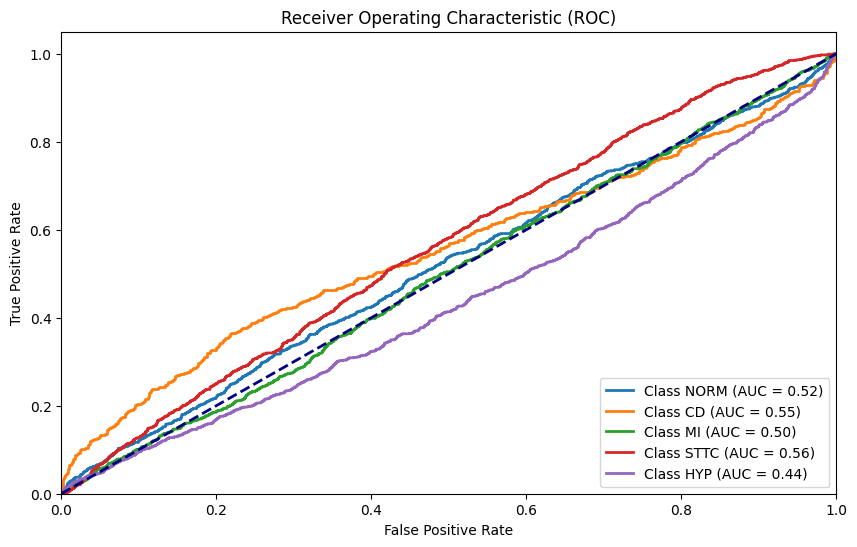

Model Size: 4.28 MB
Inference Time per Sample: 3.0239 ms
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 636.49 GFLOPs


In [17]:
# Define a DataLoader for the test dataset
batch_size = 64  # You can adjust this batch size as needed
test_dataset = TensorDataset(X_test_transposed_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 모델을 평가 모드로 설정
quantized_model.eval()

# 테스트 데이터를 모델에 전달하고 예측을 얻음
y_scores = []  # 모델의 예측 확률을 저장할 리스트
y_true = []    # 실제 레이블을 저장할 리스트

with torch.no_grad():
    for batch_data, batch_labels in test_loader:  # 이전에 정의한 test_loader를 사용
        batch_data = batch_data.to(device)
        quantized_model(batch_data)
        outputs = model(batch_data)

        # 예측 확률과 실제 레이블을 저장
        y_scores.extend(outputs.cpu().numpy())
        y_true.extend(batch_labels.cpu().numpy())

# y_true와 y_scores를 넘파이 배열로 변환
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# ROC 곡선 계산
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 그래프 그리기
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

import os

# Define a function to measure model size
def model_size(model):
    torch.save(model.state_dict(), "temp.pth")
    size_mb = os.path.getsize("temp.pth") / 1e6
    os.remove('temp.pth')
    return size_mb
# 모델 크기 측정
model_size_mb = model_size(quantized_model)
print(f'Model Size: {model_size_mb:.2f} MB')

# 추론 시간 측정
import time
num_samples = len(Y_test_tensor)
input_data = X_test_transposed_tensor.to(device)

start_time = time.time()
with torch.no_grad():
    quantized_model(input_data)

inference_time = (time.time() - start_time) / num_samples * 1000  # 밀리초 단위로 변환
print(f'Inference Time per Sample: {inference_time:.4f} ms')

# FLOPs 계산
import thop
input_data = input_data.to(device)
flops, params = thop.profile(quantized_model, inputs=(input_data,))
print(f'FLOPs: {flops / 1e9:.2f} GFLOPs')  # GFLOPs: 기가 플로팅 포인트 연산 수 (10^9 FLOPs)

